In [16]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from scipy.stats import spearmanr

# plotting style
sns.set(style="whitegrid")

In [17]:
dataset = load_dataset("sentence-transformers/stsb", split="test")

sentences1 = dataset["sentence1"]
sentences2 = dataset["sentence2"]
labels = dataset["score"]

models = [
    "sentence-transformers/all-MiniLM-L6-v2",
    "sentence-transformers/all-mpnet-base-v2",
    "sentence-transformers/paraphrase-MiniLM-L12-v2",
    "sentence-transformers/paraphrase-mpnet-base-v2",
    "sentence-transformers/distilbert-base-nli-stsb-mean-tokens",
    "sentence-transformers/bert-base-nli-mean-tokens",
]

In [18]:
def evaluate_model(model_name, s1, s2, labels, sample_size=500):
    model = SentenceTransformer(model_name, device="cpu")

    s1 = s1[:sample_size]
    s2 = s2[:sample_size]
    labels = labels[:sample_size]

    start = time.time()
    emb1 = model.encode(s1, convert_to_numpy=True, show_progress_bar=False)
    emb2 = model.encode(s2, convert_to_numpy=True, show_progress_bar=False)
    end = time.time()

    cosine_sim = np.sum(emb1 * emb2, axis=1) / (
        np.linalg.norm(emb1, axis=1) * np.linalg.norm(emb2, axis=1)
    )

    spearman, _ = spearmanr(cosine_sim, labels)
    avg_time_ms = ((end - start) / sample_size) * 1000

    return spearman, avg_time_ms, model

In [19]:
from huggingface_hub import scan_cache_dir

def get_model_size_mb(repo_id):
    cache_info = scan_cache_dir()
    for repo in cache_info.repos:
        if repo.repo_id == repo_id:
            return repo.size_on_disk / (1024 * 1024)
    return None

In [20]:
results = []

for model_name in models:
    print(f"Evaluating: {model_name}")

    accuracy, time_ms, _ = evaluate_model(
        model_name,
        sentences1,
        sentences2,
        labels
    )

    size_mb = get_model_size_mb(model_name)

    results.append([
        model_name.split("/")[-1],
        accuracy,
        time_ms,
        size_mb
    ])

df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Time_ms", "Size_MB"]
)

print(df)


Evaluating: sentence-transformers/all-MiniLM-L6-v2


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 280.92it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Evaluating: sentence-transformers/all-mpnet-base-v2


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 271.29it/s, Materializing param=pooler.dense.weight]                        
MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Evaluating: sentence-transformers/paraphrase-MiniLM-L12-v2


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 285.89it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: sentence-transformers/paraphrase-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Evaluating: sentence-transformers/paraphrase-mpnet-base-v2


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 262.47it/s, Materializing param=pooler.dense.weight]                        
MPNetModel LOAD REPORT from: sentence-transformers/paraphrase-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Evaluating: sentence-transformers/distilbert-base-nli-stsb-mean-tokens


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 188.32it/s, Materializing param=transformer.layer.5.sa_layer_norm.weight]   


Evaluating: sentence-transformers/bert-base-nli-mean-tokens


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 249.06it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: sentence-transformers/bert-base-nli-mean-tokens
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


                                  Model  Accuracy    Time_ms     Size_MB
0                      all-MiniLM-L6-v2  0.927632   7.374369   87.335937
1                     all-mpnet-base-v2  0.930934  40.843965  418.360636
2              paraphrase-MiniLM-L12-v2  0.917021  11.552238  127.953589
3              paraphrase-mpnet-base-v2  0.935278  78.517846  418.354918
4  distilbert-base-nli-stsb-mean-tokens  0.915163  35.784287  253.835472
5             bert-base-nli-mean-tokens  0.879270  47.092271  418.337442


In [21]:
# Decision Matrix
decision_matrix = df[["Accuracy", "Time_ms", "Size_MB"]].values

# Weights (sum = 1)
weights = np.array([0.50, 0.30, 0.20])

# Benefit (+1) / Cost (-1)
criteria_type = np.array([1, -1, -1])

# Normalize
norm_matrix = decision_matrix / np.sqrt((decision_matrix**2).sum(axis=0))

# Weighted normalization
weighted_matrix = norm_matrix * weights

# Ideal best and worst
ideal_best = np.where(
    criteria_type == 1, weighted_matrix.max(axis=0), weighted_matrix.min(axis=0)
)

ideal_worst = np.where(
    criteria_type == 1, weighted_matrix.min(axis=0), weighted_matrix.max(axis=0)
)

# Distances
dist_best = np.sqrt(((weighted_matrix - ideal_best) ** 2).sum(axis=1))
dist_worst = np.sqrt(((weighted_matrix - ideal_worst) ** 2).sum(axis=1))

# TOPSIS score
df["TOPSIS_Score"] = dist_worst / (dist_best + dist_worst)

# Rank
df["Rank"] = df["TOPSIS_Score"].rank(ascending=False)
df = df.sort_values("Rank")

print("\nTOPSIS Ranking:\n")
print(df)


TOPSIS Ranking:

                                  Model  Accuracy    Time_ms     Size_MB  \
0                      all-MiniLM-L6-v2  0.927632   7.374369   87.335937   
2              paraphrase-MiniLM-L12-v2  0.917021  11.552238  127.953589   
4  distilbert-base-nli-stsb-mean-tokens  0.915163  35.784287  253.835472   
1                     all-mpnet-base-v2  0.930934  40.843965  418.360636   
5             bert-base-nli-mean-tokens  0.879270  47.092271  418.337442   
3              paraphrase-mpnet-base-v2  0.935278  78.517846  418.354918   

   TOPSIS_Score  Rank  
0      0.992200   1.0  
2      0.925853   2.0  
4      0.584505   3.0  
1      0.456563   4.0  
5      0.385389   5.0  
3      0.054510   6.0  


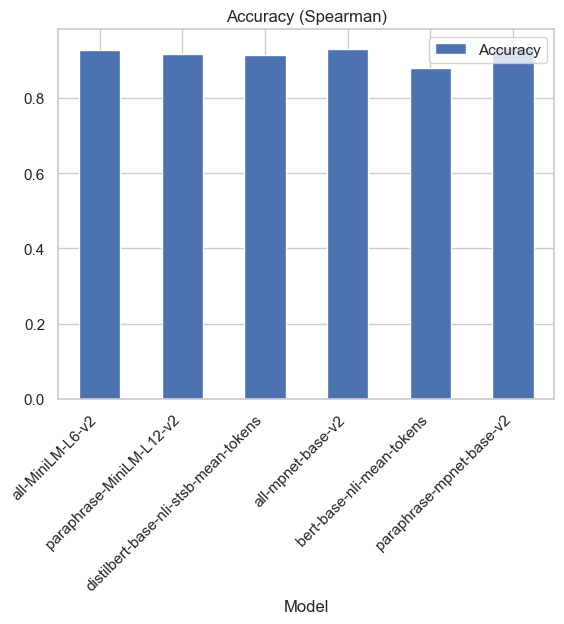

In [22]:
import matplotlib.pyplot as plt
df_plot = df.sort_values('Rank')
df_plot.plot(x='Model', y='Accuracy', kind='bar', title='Accuracy (Spearman)')
plt.xticks(rotation=45, ha='right')
plt.show()